In [129]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightPhysics.Geodesy
using Flight.FlightPhysics.Kinematics
using Flight.FlightComponents.Aircraft
using Flight.FlightAircraft.C172FBW

using UnPack
using ControlSystems
using RobustAndOptimalControl

In [318]:
#generate design linear model, high airspeed, forward CG
design_ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

design_ac.physics.airframe.pld.u.m_pilot = 75
design_ac.physics.airframe.pld.u.m_copilot = 75
design_ac.physics.airframe.pld.u.m_lpass = 0
design_ac.physics.airframe.pld.u.m_rpass = 0
design_ac.physics.airframe.pld.u.m_baggage = 0

design_trim_params = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    ψ_nb = 0.0,
    TAS = 60.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel_load = 1,
    mixture = 0.5,
    flaps = 0.0)

design_lm = linearize!(design_ac, design_trim_params)

#generate test linear model, low airspeed, rear CG
test_ac = Cessna172FBWBase(NED()) |> System #linearization requires NED kinematics

test_ac.physics.airframe.pld.u.m_pilot = 75
test_ac.physics.airframe.pld.u.m_copilot = 75
test_ac.physics.airframe.pld.u.m_lpass = 0
test_ac.physics.airframe.pld.u.m_rpass = 0
test_ac.physics.airframe.pld.u.m_baggage = 50

test_trim_params = C172FBW.TrimParameters(
    Ob = Geographic(LatLon(), HOrth(1000)),
    ψ_nb = 0.0,
    TAS = 30.0,
    γ_wOb_n = 0.0,
    ψ_lb_dot = 0.00,
    θ_lb_dot = 0.0,
    β_a = 0.0,
    fuel_load = 0.5,
    mixture = 0.5,
    flaps = 1.0)

test_lm = linearize!(test_ac, test_trim_params)

lm = design_lm
# lm = test_lm

u_lon_labels = [:throttle_cmd, :elevator_cmd]
x_lon_labels = [:q, :θ, :v_x, :v_z, :α_filt, :ω_eng, :thr_v, :thr_p, :ele_v, :ele_p]
y_lon_labels = [:q, :θ, :α, :TAS, :f_x, :f_z, :γ, :ω_eng]

long_dyn_lss = submodel(lm; u = u_lon_labels, x = x_lon_labels, y = y_lon_labels)

#the open-loop system, with throttle and elevator commands as inputs is our
#baseline plant
thr_ele_MIMO = named_ss(ss(long_dyn_lss), x = x_lon_labels, y = y_lon_labels, u = u_lon_labels)

NamedStateSpace{Continuous, Float64}
A = 
 -6.270965834562622   -4.9128583760604805e-6  -0.0012773940700841074  -4.452843337102395       181.4099275403215      0.005590114433137395    0.0                   0.0                0.0                  19.831156263031584
  0.9999998985657131  -9.631080592611111e-15   1.5781490192954896e-7   7.966035922125587e-10     0.0                  0.0                     0.0                   0.0                0.0                   0.0
  3.1856668800772354  -9.777059539767663      -0.10257026000332585     2.548256545716299      -102.40082366336628     0.021474800447273897    0.0                   0.0                0.0                 -10.368669155468751
 57.843900740702324   -0.049347348050226      -0.3090023745700086     -3.837246439246684        52.109868846192725    0.000578842732883477    0.0                   0.0                0.0                   8.074438570264409
  0.0                  0.0                    -0.004206277015980426    0.8333227

## 1. Pitch Rate

In [319]:
e2q = thr_ele_MIMO[:q, :elevator_cmd]
P_e2q = ss(e2q)

zpk(P_e2q) |> display
poles(P_e2q) |> display

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
                                                     (1.0s + 49.618960571157)(1.0s + 15.701000777816986)(1.0s + 2.393381133656639)(1.0s + 2.811702841795787e-5)(1.0s + 0.05490929575530281)
78290.26685292293--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                 (1.0s + 46.44250629973288)(1.0s^2 + 75.39822368615503s + 3947.8417604357433)(1.0s + 15.706624972440295)(1.0s^2 + 13.662636736027123s + 109.25001742968553)(1.0s^2 + 0.0398261615380298s + 0.04195991606255757)

Continuous-time transfer function model

10-element Vector{ComplexF64}:
   -46.442506299732784 + 0.0im
    -15.70662497244027 + 0.0im
    -6.831318368013567 + 7.910948538862207im
    -6.831318368013567 - 7.910948538862207im
 -0.019913080769021492 + 0.203871001559424im
 -0.019913080769021492 - 0.203871001559424im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im
    -37.69911184307752 + 50.26548245743669im
    -37.69911184307752 - 50.26548245743669im

We have:
- Two pairs of very fast imaginary poles, corresponding to the throttle and elevator actuators
- A pair of fast imaginary poles, corresponding to the short period mode
- A pair of slow imaginary poles, corresponding to the phugoid mode
- A very fast real pole, corresponding to the AoA filter
- A fast real pole, corresponding to the powerplant response (in particular, the propeller moment of inertia)

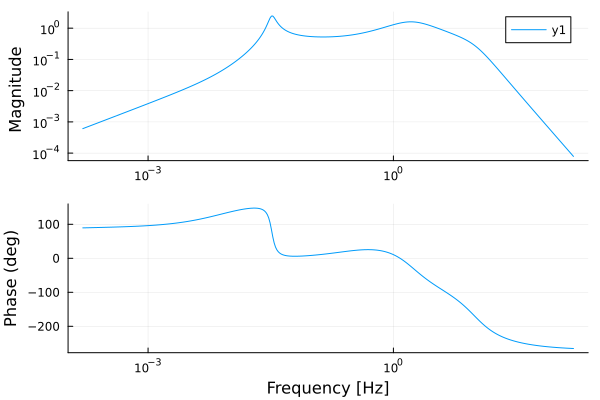

In [320]:
bodeplot(P_e2q, hz = true)

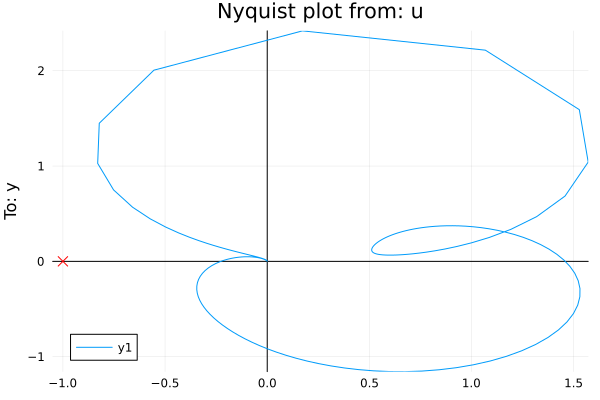

In [321]:
nyquistplot(P_e2q)

In [322]:
#1) from the Bode plot, we can see that we need to add a double integrator to
#   achieve a type 1 loop transfer function (-20dB/decade slope as ω->0)
C1_q = zpk([], [0.0, 0.0], 1) |> ss
L1_q = series(C1_q, P_e2q) #loop TF

StateSpace{Continuous, Float64}
A = 
 -6.270965834562622   -4.9128583760604805e-6  -0.0012773940700841074  -4.452843337102395       181.4099275403215      0.005590114433137395    0.0                   0.0                0.0                  19.831156263031584     0.0              0.0
  0.9999998985657131  -9.631080592611111e-15   1.5781490192954896e-7   7.966035922125587e-10     0.0                  0.0                     0.0                   0.0                0.0                   0.0                   0.0              0.0
  3.1856668800772354  -9.777059539767663      -0.10257026000332585     2.548256545716299      -102.40082366336628     0.021474800447273897    0.0                   0.0                0.0                 -10.368669155468751     0.0              0.0
 57.843900740702324   -0.049347348050226      -0.3090023745700086     -3.837246439246684        52.109868846192725    0.000578842732883477    0.0                   0.0                0.0                   8.074438570264

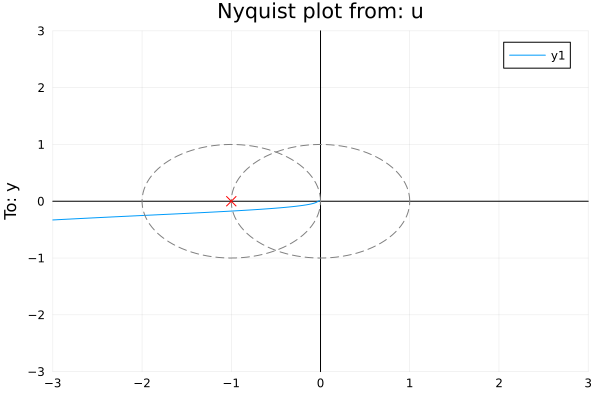

In [323]:
nyquist_fig = nyquistplot(L1_q; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-3,3), xlims = (-3,3))

(ω_fxo, gm, ω_gxo, pm) = ([7.579698687426771;;], [39.38937068753951;;], [0.7267371900843445;;], [9.904572564497442;;])


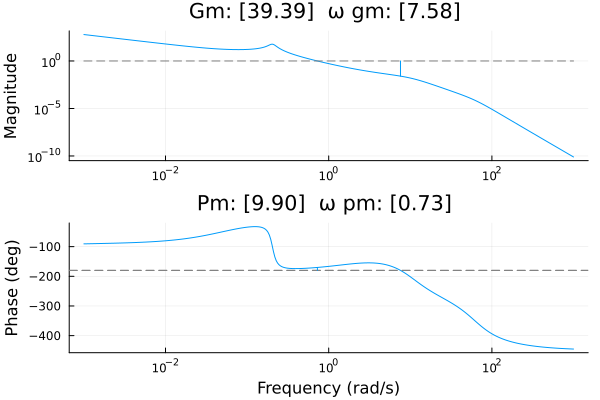

In [324]:
ω_fxo, gm, ω_gxo, pm = margin(L1_q)
@show ω_fxo, gm, ω_gxo, pm
marginplot(L1_q)

We are seriously lacking phase margin. This may be solved by adding a lead compensator around the gain crossover frequency, $\omega_{gxo}$

0.3908168177536266

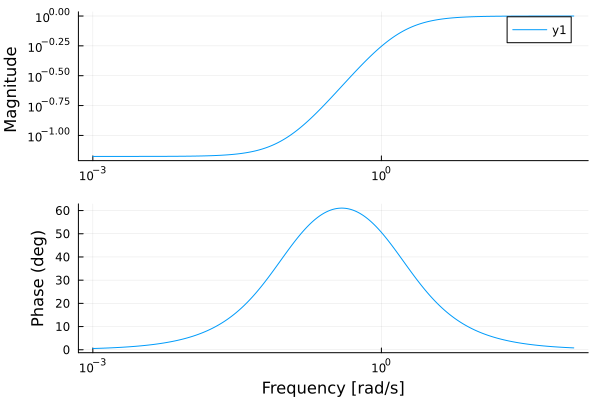

In [325]:
Lc1_q = zpk([-0.1], [-1.5], 1) |> ss
g_Lc1, φ_Lc1, ω_Lc1 = map(vec, bode(Lc1_q))
(φ_Lc1_peak, i_Lc1_peak) = findmax(φ_Lc1)
ω_Lc1_peak = ω_Lc1[i_Lc1_peak]
ω_Lc1_peak |> display
bodeplot(Lc1_q)

In [326]:
C2_q = series(C1_q, Lc1_q)
L2_q = series(C2_q, P_e2q)

StateSpace{Continuous, Float64}
A = 
 -6.270965834562622   -4.9128583760604805e-6  -0.0012773940700841074  -4.452843337102395       181.4099275403215      0.005590114433137395    0.0                   0.0                0.0                  19.831156263031584      0.0                0.0              0.0
  0.9999998985657131  -9.631080592611111e-15   1.5781490192954896e-7   7.966035922125587e-10     0.0                  0.0                     0.0                   0.0                0.0                   0.0                    0.0                0.0              0.0
  3.1856668800772354  -9.777059539767663      -0.10257026000332585     2.548256545716299      -102.40082366336628     0.021474800447273897    0.0                   0.0                0.0                 -10.368669155468751      0.0                0.0              0.0
 57.843900740702324   -0.049347348050226      -0.3090023745700086     -3.837246439246684        52.109868846192725    0.000578842732883477    0.0              

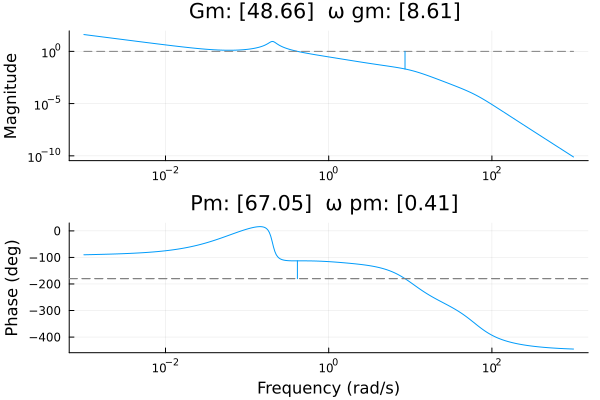

In [327]:
marginplot(L2_q)

Stability-wise, this looks good. However, we need to check the closed-loop response.

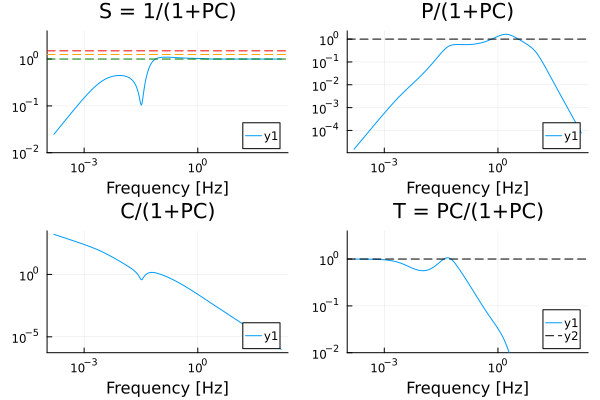

In [328]:
gangoffourplot(P_e2q, C2_q, hz = true)

The sensitivity TF S looks OK. We have good attenuation of low frequency noise/measurement disturbances and a small peak sensitivity. However, the low frequency dip in the complementary transfer function T, which determines the closed-loop input-output response, suggests we are going to have trouble tracking even low frequency inputs. Therefore, even though the steady state error is guaranteed to be zero by the negative zero-frequency slope of the loop transfer function, we can expect the step input response to be unsatisfactory.

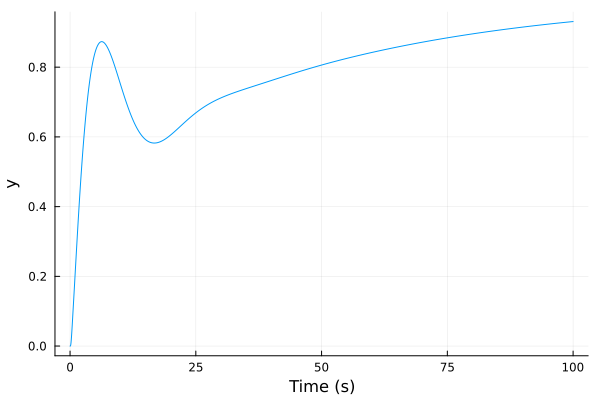

In [329]:
T2_q = L2_q/(1+L2_q) #equivalent to T2_q = feedback(L2_q)
step(T2_q, 100) |> plot

Since we have lots of gain margin, we can try to improve this by turning up the loop gain. With a loop gain $k_p$, the gain margin will decrease $1/k_p$.

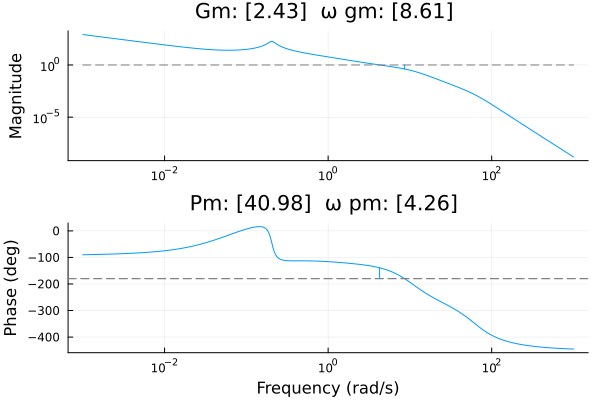

In [330]:
C3_q = series(C2_q, ss(20))
L3_q = series(C3_q, P_e2q)
marginplot(L3_q)

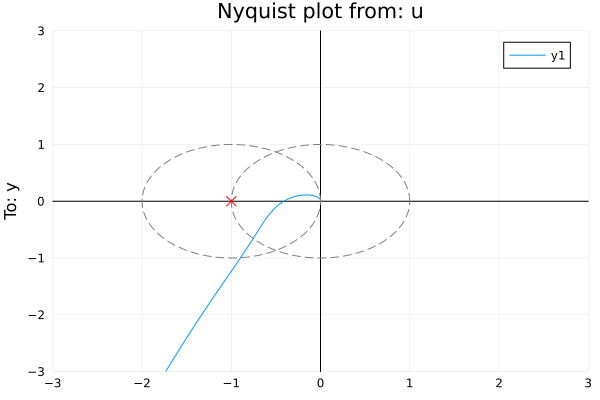

In [331]:
nyquist_fig = nyquistplot(L3_q; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-3,3), xlims = (-3,3))

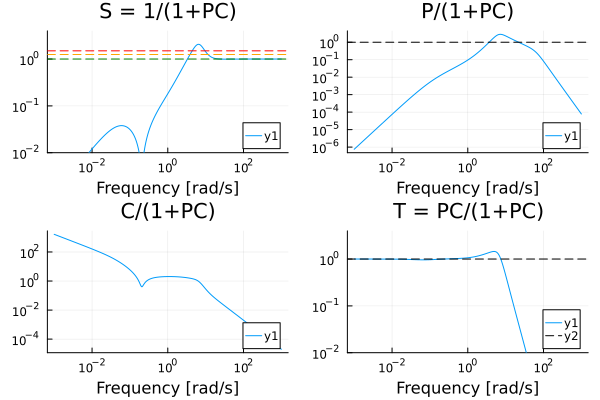

In [332]:
gangoffourplot(P_e2q, C3_q)

But now, both the sensitivity function and Bode plots tell us that both gain and phase margin are now inacceptably low.

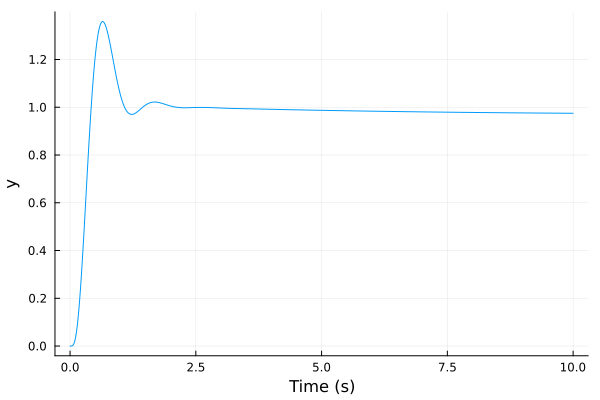

In [333]:
T3_q = L3_q/(1+L3_q) #equivalent to T2_q = feedback(L2_q)
step(T3_q, 10) |> plot

As expected, this also results in an unacceptable overshoot. We can add gain margin around the phase crossover frequency with another lead compensator.

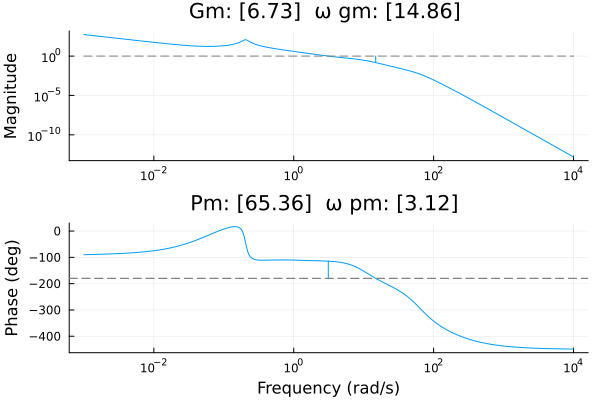

In [334]:
Lc3_q = zpk([-10], [-150], 10) |> ss
C4_q = series(C3_q, Lc3_q)
# C4_q = series(2C4_q, Lc3_q)
L4_q = series(C4_q, P_e2q)
marginplot(L4_q)

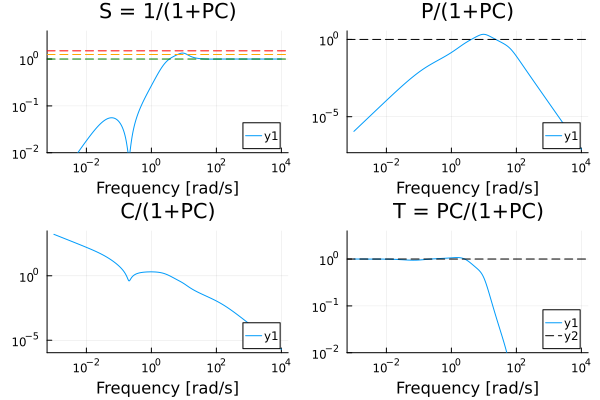

In [335]:
gangoffourplot(P_e2q, C4_q)

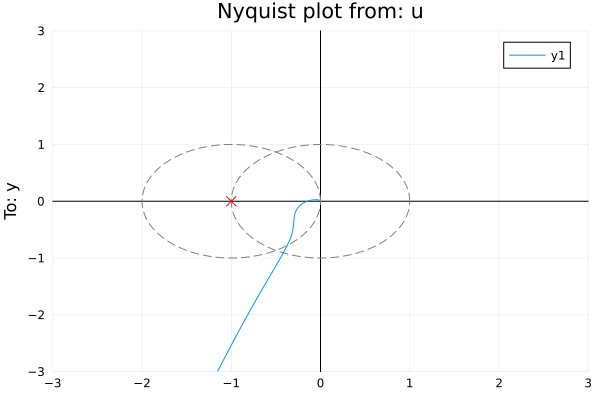

In [336]:
nyquist_fig = nyquistplot(L4_q; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-3,3), xlims = (-3,3))

The magnitude of the sensitivity TF S = 1 + L represents the amplification or attenuation with which noise (measurement) disturbances appear at the plant's output. The radius vector from (-1, 0) to the loop transfer function curve L in the Nyquist plot is the inverse of the sensitivity TF S. Therefore, frequencies for which this curve is outside the unit circle centered at (-1, 0) correspond to |S|<1, and measurement disturbances at those frequencies are attenuated.

In [337]:
S4_q = 1/(1+L4_q) #sensitivity TF (noise disturbance to output)
hinfnorm(S4_q) |> display #maximum sensitivity and corresponding frequency

(1.3433180252516363, 9.132704313043577)

StepInfo:
Initial value:     0.000
Final value:       0.963
Step size:         0.963
Peak:              1.080
Peak time:         1.132 s
Overshoot:         12.19 %
Undershoot:         0.00 %
Settling time:     5.005 s
Rise time:         0.338 s


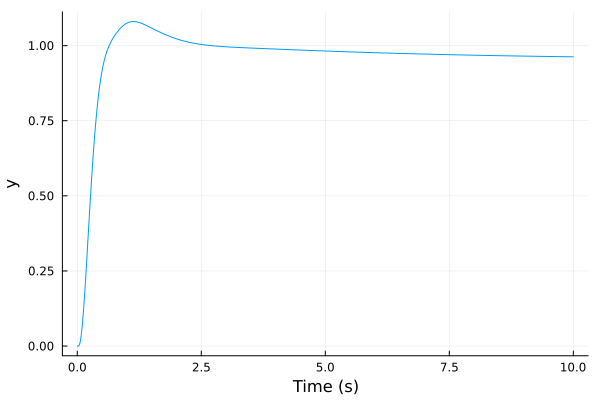

In [338]:
T4_q = L4_q/(1+L4_q) #complementary sensitivity TF: input disturbance to input
step(T4_q, 10) |> stepinfo |> display
step(T4_q, 10) |> plot

The closed loop response is still not good enough. The loop transfer function has insufficient low frequency gain. To increase the loop gain we need still more gain margin around the crossover frequency, which we can achieve with a lead compensator. On top of that, we can add a lag compensator to simply add some low frequency gain.

0.032005101340698686

29.996640569218354

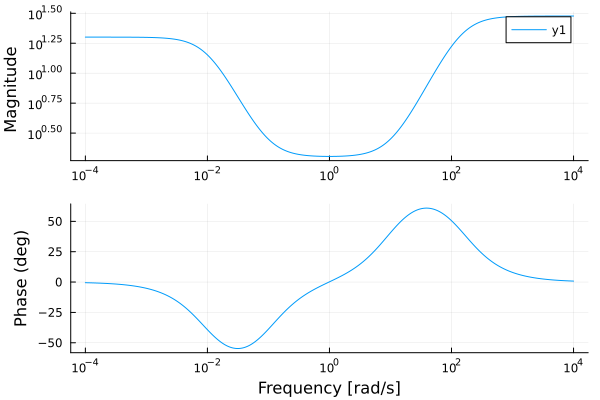

In [339]:
lag = zpk([-0.1], [-0.01], 1) |> ss
lead = zpk([-10], [-150], 30) |> ss
Lc5_q = lead * lag

g_Lc5, φ_Lc5, ω_Lc5 = map(vec, bode(Lc5_q))
(φ_Lc5_peak, i_Lc5_peak) = findmin(φ_Lc5)
ω_Lc5_peak = ω_Lc5[i_Lc5_peak]
ω_Lc5_peak |> display
maximum(g_Lc5) |> display
bodeplot(Lc5_q)

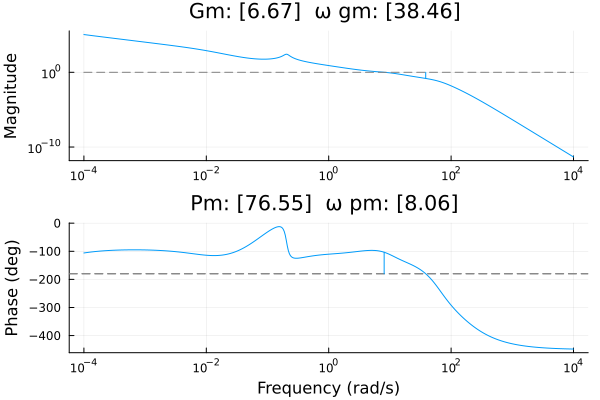

In [340]:
C5_q = series(C4_q, Lc5_q)
L5_q = series(C5_q, P_e2q)
marginplot(L5_q)

In [341]:
T5_q = feedback(L5_q)
step(T5_q, 10) |> stepinfo
# step(T5_q, 10) |> plot

StepInfo:
Initial value:     0.000
Final value:       0.990
Step size:         0.990
Peak:              1.050
Peak time:         0.862 s
Overshoot:          5.99 %
Undershoot:         0.00 %
Settling time:     2.298 s
Rise time:         0.166 s


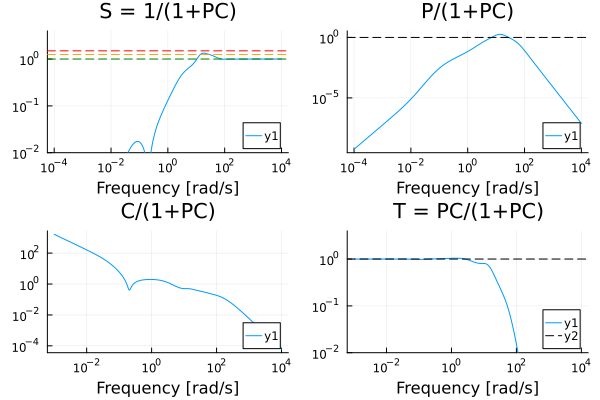

In [342]:
gangoffourplot(P_e2q, C5_q)

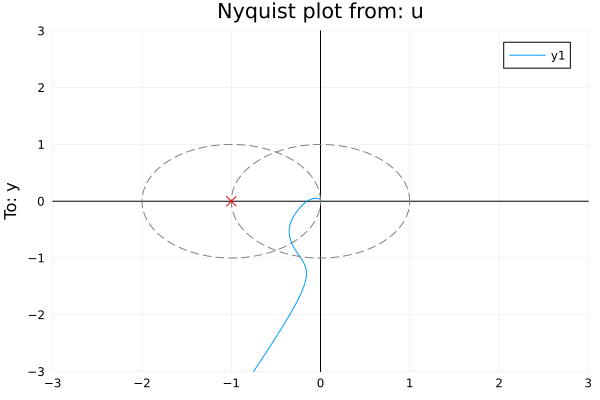

In [343]:
nyquist_fig = nyquistplot(L5_q; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-3,3), xlims = (-3,3))

With this performance, we can consider the pitch rate compensator design finished. Its final structure consists of two pure integrators, two lead compensators and a gain:

In [344]:
qcmp_tf = C5_q
qcmp = named_ss(ss(qcmp_tf), :qcmp; u = :q_err, y = :elevator_cmd)
zpk(qcmp) |> display
zpkdata(qcmp)[1]

TransferFunction{Continuous, ControlSystemsBase.SisoZpk{Float64, ComplexF64}}
      (1.0s^2 + 19.999999999999822s + 100.00000000000188)(1.0s + 0.10000001009714572)(1.0s + 0.09999998990286624)
6000.0-----------------------------------------------------------------------------------------------------------
                           (1.0s + 150.0)(1.0s + 150.0)(1.0s + 1.5)(1.0s + 0.01)(1.0s)(1.0s)

Continuous-time transfer function model

1×1 Matrix{Vector{ComplexF64}}:
 [-9.999999999999911 + 1.912109051608294e-6im, -9.999999999999911 - 1.912109051608294e-6im, -0.10000001009714572 + 0.0im, -0.09999998990286624 + 0.0im]

Now we have a SISO compensator design, we need to use it to close the loop in the MIMO plant.

First, we will do it manually. The baseline MIMO system has two inputs, throttle_cmd and elevator_cmd. Our SISO compensator receives q_err as an input and outputs elevator_cmd. So the MIMO version of our SISO compensator, which will be placed upstream of the MIMO plant, must receive [throttle_cmd, q_err] as input and output [throttle_cmd, elevator_cmd]. Therefore, it must apply an unit gain to its first input throttle_cmd to let it pass through unchanged, and apply the SISO compensator to its second input q_err to obtain elevator_cmd.

The setpoint vector to be applied to the closed-loop MIMO system is r = [throttle_cmd, q_dmd]. The input to the MIMO compensator must be u = [throttle_cmd, q_err] = r - f = [throttle_cmd, q_dmd] - [0, q]. So we need a matrix gain that premultiplies the 7-component output vector of thr_ele_MIMO, and produces a 2-component vector [0, q]. This will be a 2xNy matrix K_q with all entries set to zero except K_q[2, 1] (the nonzero output goes in the second component, and it is q, the first element in thr_ele_MIMO's output vector)

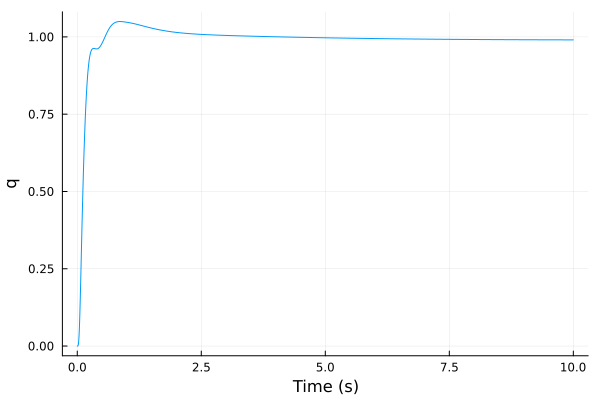

In [345]:
#create a diagonal MIMO system with a unit feedthrough system and the pitch
#rate compensator
qcmp_MIMO = append(ss(1.0), ss(qcmp))
#prepend it to the plant
qcmp_thr_ele_MIMO = series(qcmp_MIMO, ss(thr_ele_MIMO))

#construct feedback system K_q_ss
K_q = zeros(2, 8)
K_q[2,1] = 1 #selects q from thr_ele_MIMO and puts it in the second row
K_q_ss = ss(K_q) #creates a ss with no dynamics and K_q as feedthrough

#create a feedback loop with K_q_ss in the feedback path
thr_q_MIMO_man = feedback(qcmp_thr_ele_MIMO, K_q_ss)

#finally, convert it to a NamedStateSpace with the appropriate labels
thr_q_MIMO_man = named_ss(thr_q_MIMO_man, :thr_q, u = [:throttle_cmd, :q_dmd], y = y_lon_labels)

#check we get the same response as with the SISO closed loop
qdmd2q_man = thr_q_MIMO_man[:q, :q_dmd]
step(qdmd2q_man, 10) |> plot

All this is made much more straightforward by the connect function from RobustAndOptimalControl.jl

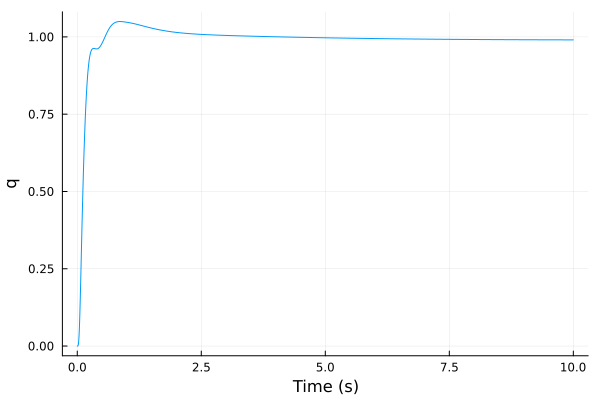

In [346]:
qsum = sumblock("q_err = q_dmd - q")
thr_q_MIMO = connect([qsum, qcmp, thr_ele_MIMO], [:q_err=>:q_err, :q=>:q, :elevator_cmd=>:elevator_cmd], w1 = [:throttle_cmd, :q_dmd], z1 = y_lon_labels)

#verify we get the same response as with the SISO closed loop
qdmd2q = thr_q_MIMO[:q, :q_dmd]
step(qdmd2q, 10) |> plot

#thr_q_MIMO is our new plant baseline: longitudinal dynamics with embedded pitch
#rate control and throttle_cmd and q_dmd as inputs

## 2. Pitch Angle

The starting plant is the longitudinal dynamics augmented with embedded pitch rate control.

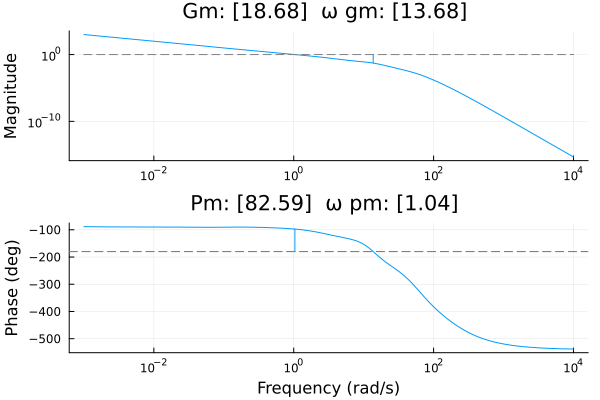

In [347]:
qdmd2θ = thr_q_MIMO[:θ, :q_dmd]
θcmp = named_ss(ss(1.0), :θcmp; u = :θ_err, y = :q_dmd)
θcmp_qdmd2θ = series(θcmp, qdmd2θ)
marginplot(θcmp_qdmd2θ)

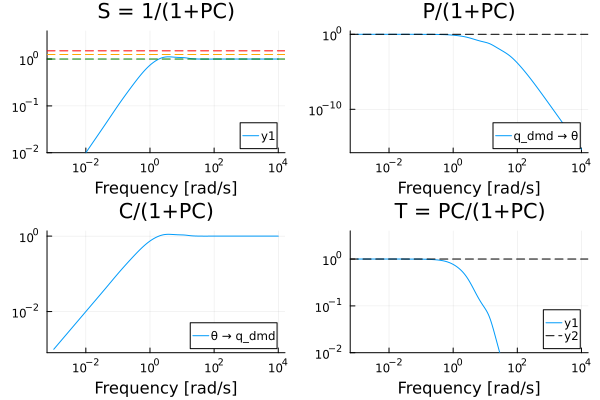

In [348]:
gangoffourplot(qdmd2θ, θcmp)

In [349]:
θcmp_qdmd2θ_cl = feedback(θcmp_qdmd2θ)

NamedStateSpace{Continuous, Float64}
A = 
    -150.0               23.040000000000003  -2800.0                  -17920.0                   12800.0                  0.0   0.0                  0.0                     0.0                     0.0                       0.0                  0.0                     0.0                   0.0
       0.0               -0.01                 -10.9375                  -70.0                      50.0                  0.0   0.0                  0.0                     0.0                     0.0                       0.0                  0.0                     0.0                   0.0
       0.0                0.0                 -150.0                    -896.0                     640.0                  0.0   0.0                  0.0                     0.0                     0.0                       0.0                  0.0                     0.0                   0.0
       0.0                0.0                    0.0                      -1

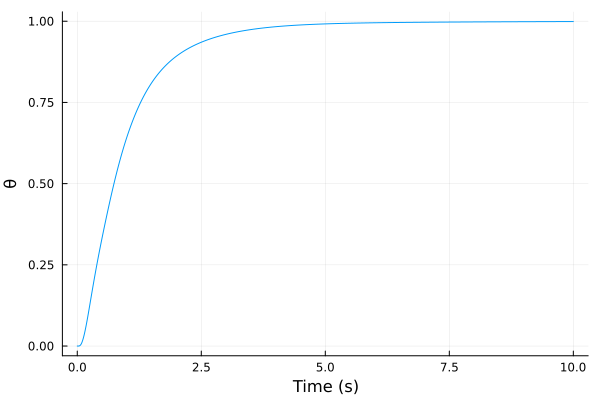

In [350]:
step(θcmp_qdmd2θ_cl, 10) |> plot